In [1]:
import re
import pandas as pd
import torch
from wordcloud import WordCloud
from collections import defaultdict
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
import seaborn as sns
import matplotlib.pyplot as plt
from string import punctuation
from nltk.stem import WordNetLemmatizer
from collections import Counter
import os
from pathlib import Path
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
nltk.download('stopwords')

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\levan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\levan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Explore the Data

In [2]:
home_dir = os.getcwd()
if not os.path.exists(Path(home_dir, 'data')):
    os.mkdir(Path(home_dir, 'data'))
data_path = Path(home_dir, 'data')
data_path

WindowsPath('c:/Users/levan/Documents/מסמכים של ניר/אוניברסיטת תל אביב/2022-2023/נושאים מתקדמים בלמידה עמוקה/פרויקט/news-dl-project/data')

In [3]:
data = pd.read_csv(Path(data_path, 'ireland-news-headlines.csv'))
data = data.drop_duplicates().dropna()

In [4]:
data.head()

,publish_date,headline_category,headline_text
0,19960102,news,UUP sees possibility of voting Major out
1,19960102,news,Pubs targeted as curbs on smoking are extended
2,19960102,news,Papers reveal secret links with O'Neill cabinet
3,19960102,news,Domestic chaos as Italy takes EU presidency
4,19960102,news,Learning about the star to which we owe life


In [5]:
data.groupby('headline_category').size()

headline_category
business                          111435
business.agribusiness-and-food      3915
business.commercial-property       12360
business.companies                   752
business.construction               1451
                                   ...  
sport.golf                          6736
sport.others                       14265
sport.racing                        5551
sport.rugby                        23318
sport.soccer                       40903
Length: 103, dtype: int64

In [6]:
data.shape

(1611488, 3)

Update the categories

In [7]:
data = data.reset_index(drop=True)

In [8]:
category_counts = data['headline_category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort the categories by count in ascending order
sorted_categories = category_counts.sort_values('Count')

# Display the 10 categories with the lowest count
lowest_categories = sorted_categories.head(100)
print(lowest_categories)

                            Category  Count
102          news.health.coronavirus    104
101  lifestyle.abroad.working-abroad    116
100           business.markets.bonds    127
99                   news.technology    191
98         lifestyle.food.restaurant    203
..                               ...    ...
7                       news.ireland  30241
6                       sport.soccer  40903
5                            culture  45799
4                            opinion  49946
3                    opinion.letters  79276

[100 rows x 2 columns]


In [9]:
# update the category to be only 1 word after the dot
data['updated_category'] = ['.'.join(data['headline_category'][i].split('.')[:2]) for i in range(data.shape[0])]

In [10]:
category_counts = data['updated_category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort the categories by count in ascending order
sorted_categories = category_counts.sort_values('Count')

# Display the 10 categories with the lowest count
lowest_categories = sorted_categories.head(50)
print(lowest_categories)

                          Category  Count
61                 news.technology    191
60              culture.tuarascail    244
59              business.companies    752
58                    news.offbeat    841
57            culture.game-reviews    988
56             business.innovation   1112
55                  culture.treibh   1174
54                   culture.media   1177
53           business.construction   1451
52                   business.work   2056
51                  culture.design   2185
50                culture.heritage   2218
49                lifestyle.abroad   2652
48          business.manufacturing   2733
47                   culture.stage   3052
46       business.personal-finance   3093
45          business.health-pharma   3156
44               lifestyle.fashion   3277
43            culture.tv-radio-web   3658
42                   news.consumer   3771
41               opinion.editorial   3851
40                    news.science   3855
39  business.agribusiness-and-food

# Visualization

### Distribution of Headlines Across Subcategories

The purpose of the plot is to visualize the distribution of headlines across different categories, specifically focusing on subcategories related to main category.

By counting the number of headlines in each subcategory the plot allows us for a visual comparison of the headline counts across different categories.

This visualization provides insights into the relative prominence or prevalence of news-related topics within the dataset.

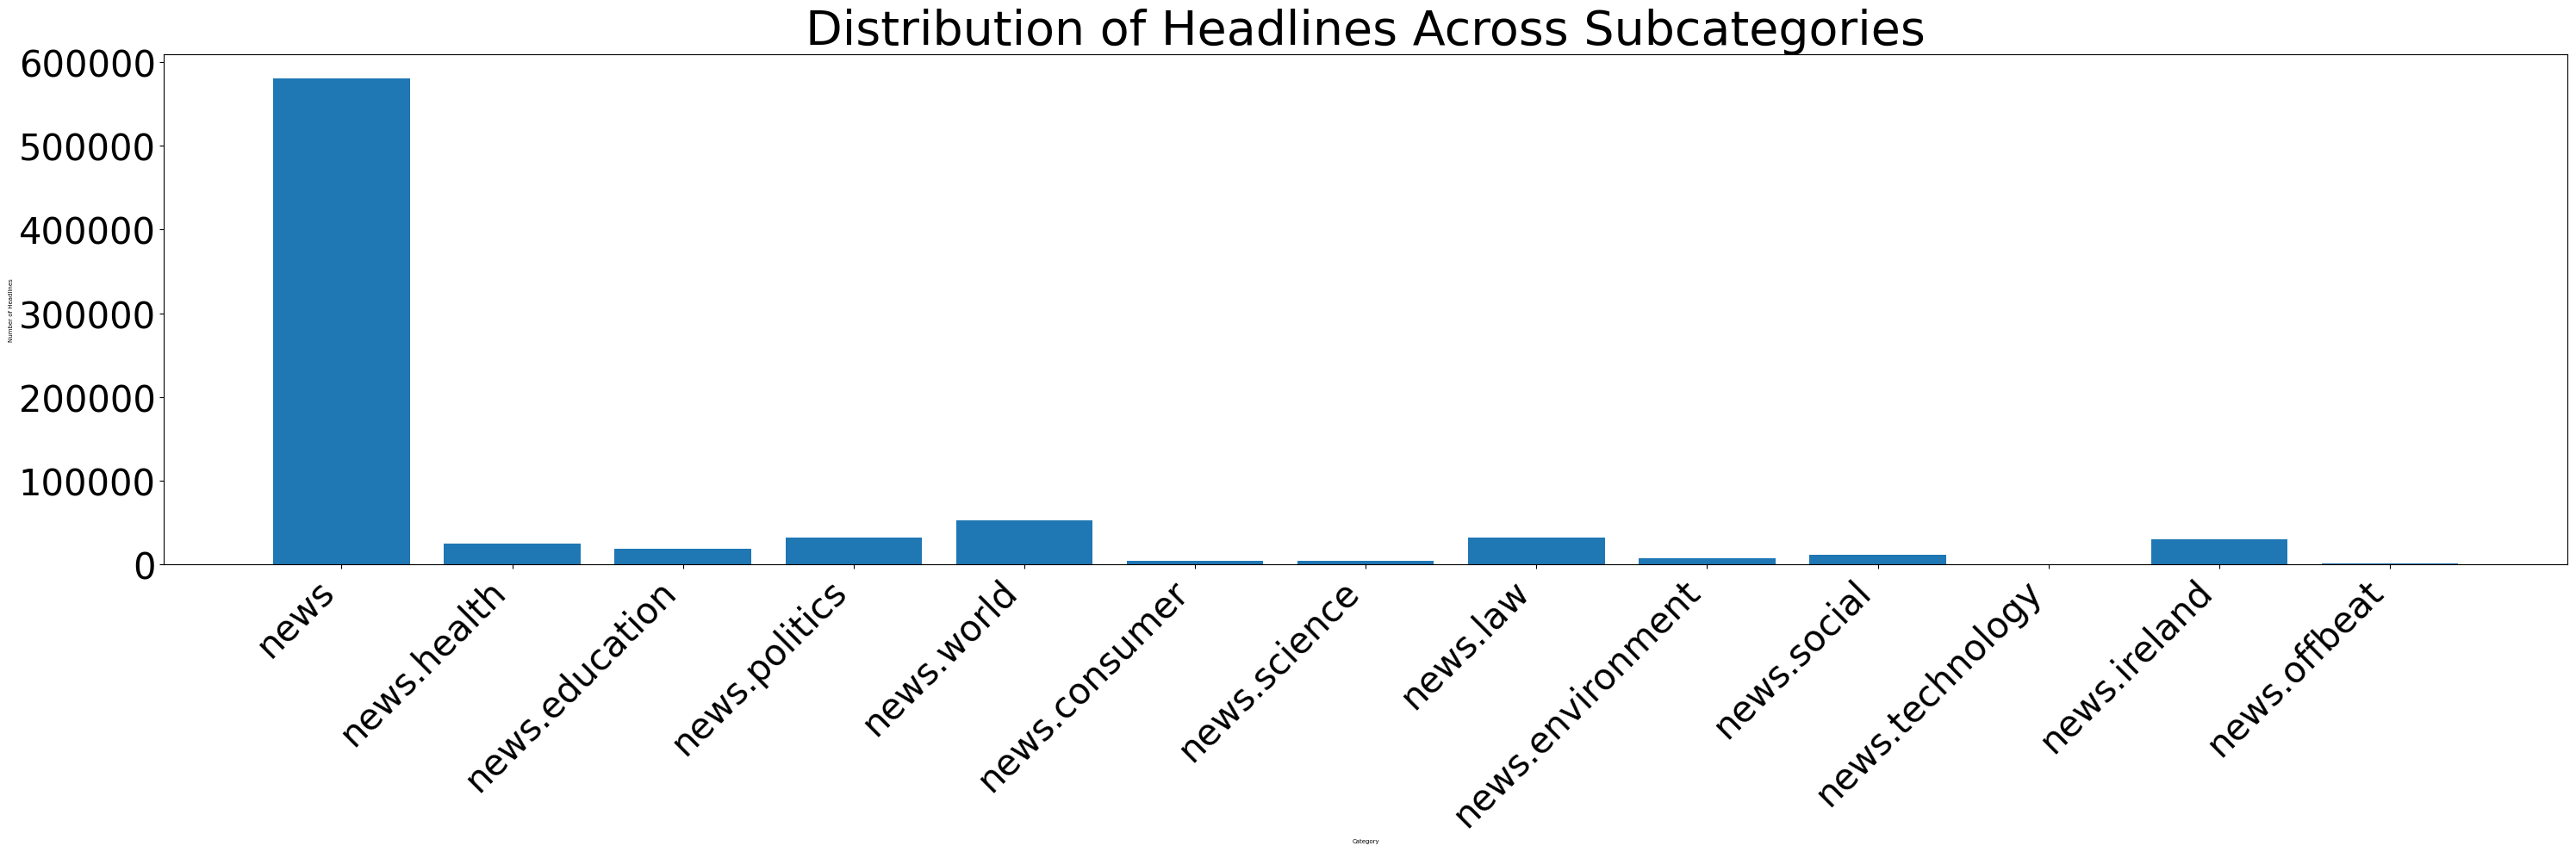

In [31]:
def number_of_rows_in_subcategory_per_category():
    # Count the number of headlines per category - please replace the main category
    categories = defaultdict(int)
    filtered_categories = data[data['updated_category'].str.startswith('news')]['updated_category'].unique()

    categories = defaultdict(int)
    for category in filtered_categories:
        count = len(data[data['updated_category'] == category])
        categories[category]=count

    # Create a bar chart of the headline counts
    plt.bar(range(len(categories)), list(categories.values()))
    plt.xticks(range(len(categories)), list(categories.keys()), rotation=45, ha='right',fontsize=30)
    plt.xlabel('Category',fontsize=5)
    plt.ylabel('Number of Headlines',fontsize=5)
    plt.tick_params(axis='y', labelsize=30)
    plt.title("Distribution of Headlines Across Subcategories",fontsize=40)
    plt.tight_layout()
    plt.rcParams['figure.figsize'] = [30, 10]
    plt.show()

# Call the function
number_of_rows_in_subcategory_per_category()

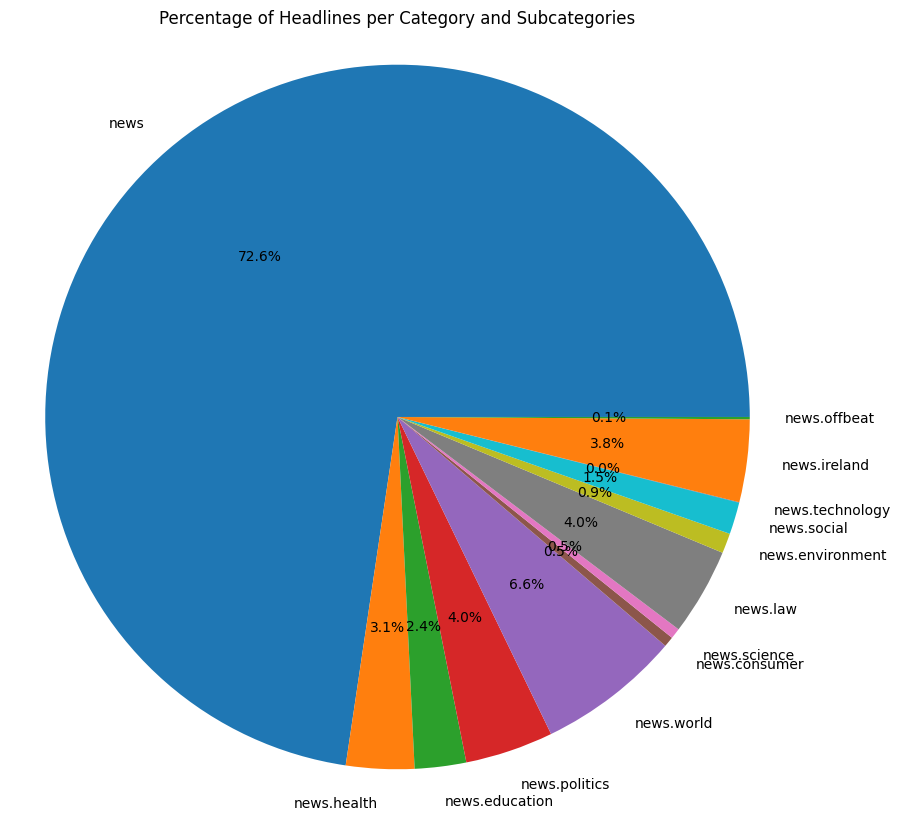

In [12]:
def percentage_of_headlines_per_category():
    # Calculate the percentage of headlines per category and its subcategories
    categories = defaultdict(int)
    filtered_categories = data[data['updated_category'].str.startswith('news')]['updated_category'].unique()

    total_headlines = len(data[data['updated_category'].str.startswith('news')])

    for category in filtered_categories:
        count = len(data[data['updated_category'] == category])
        percentage = (count / total_headlines) * 100
        categories[category] = percentage

    # Set the figure size
    plt.figure(figsize=(10, 10))
    # Create a pie chart of the headline percentages
    plt.pie(list(categories.values()), labels=list(categories.keys()), autopct='%1.1f%%')
    plt.title("Percentage of Headlines per Category and Subcategories")
    plt.axis('equal')
    plt.show()
# Call the function
percentage_of_headlines_per_category()


### Explaination of the results :
As we can see each main category has multiply sub-categories, and accross all main categories we can see that the main category has more then 50% of the headlins.

By visualizing the distribution of headlines through this plots, we gain a better understanding of how the headlines are divided among the main categories and their sub-categories.


This visualization helps identify the dominance of certain topics or themes represented by the main categories and highlights potential disparities in headline representation across different categories.

### Distribution of Headlines Across Main categories

The purpose of the plot is to visualize the distribution of headlines across main categories.

The data has been grouped based on the main category of each headline. This grouping allows for an overview of the distribution of headlines across different main categories.

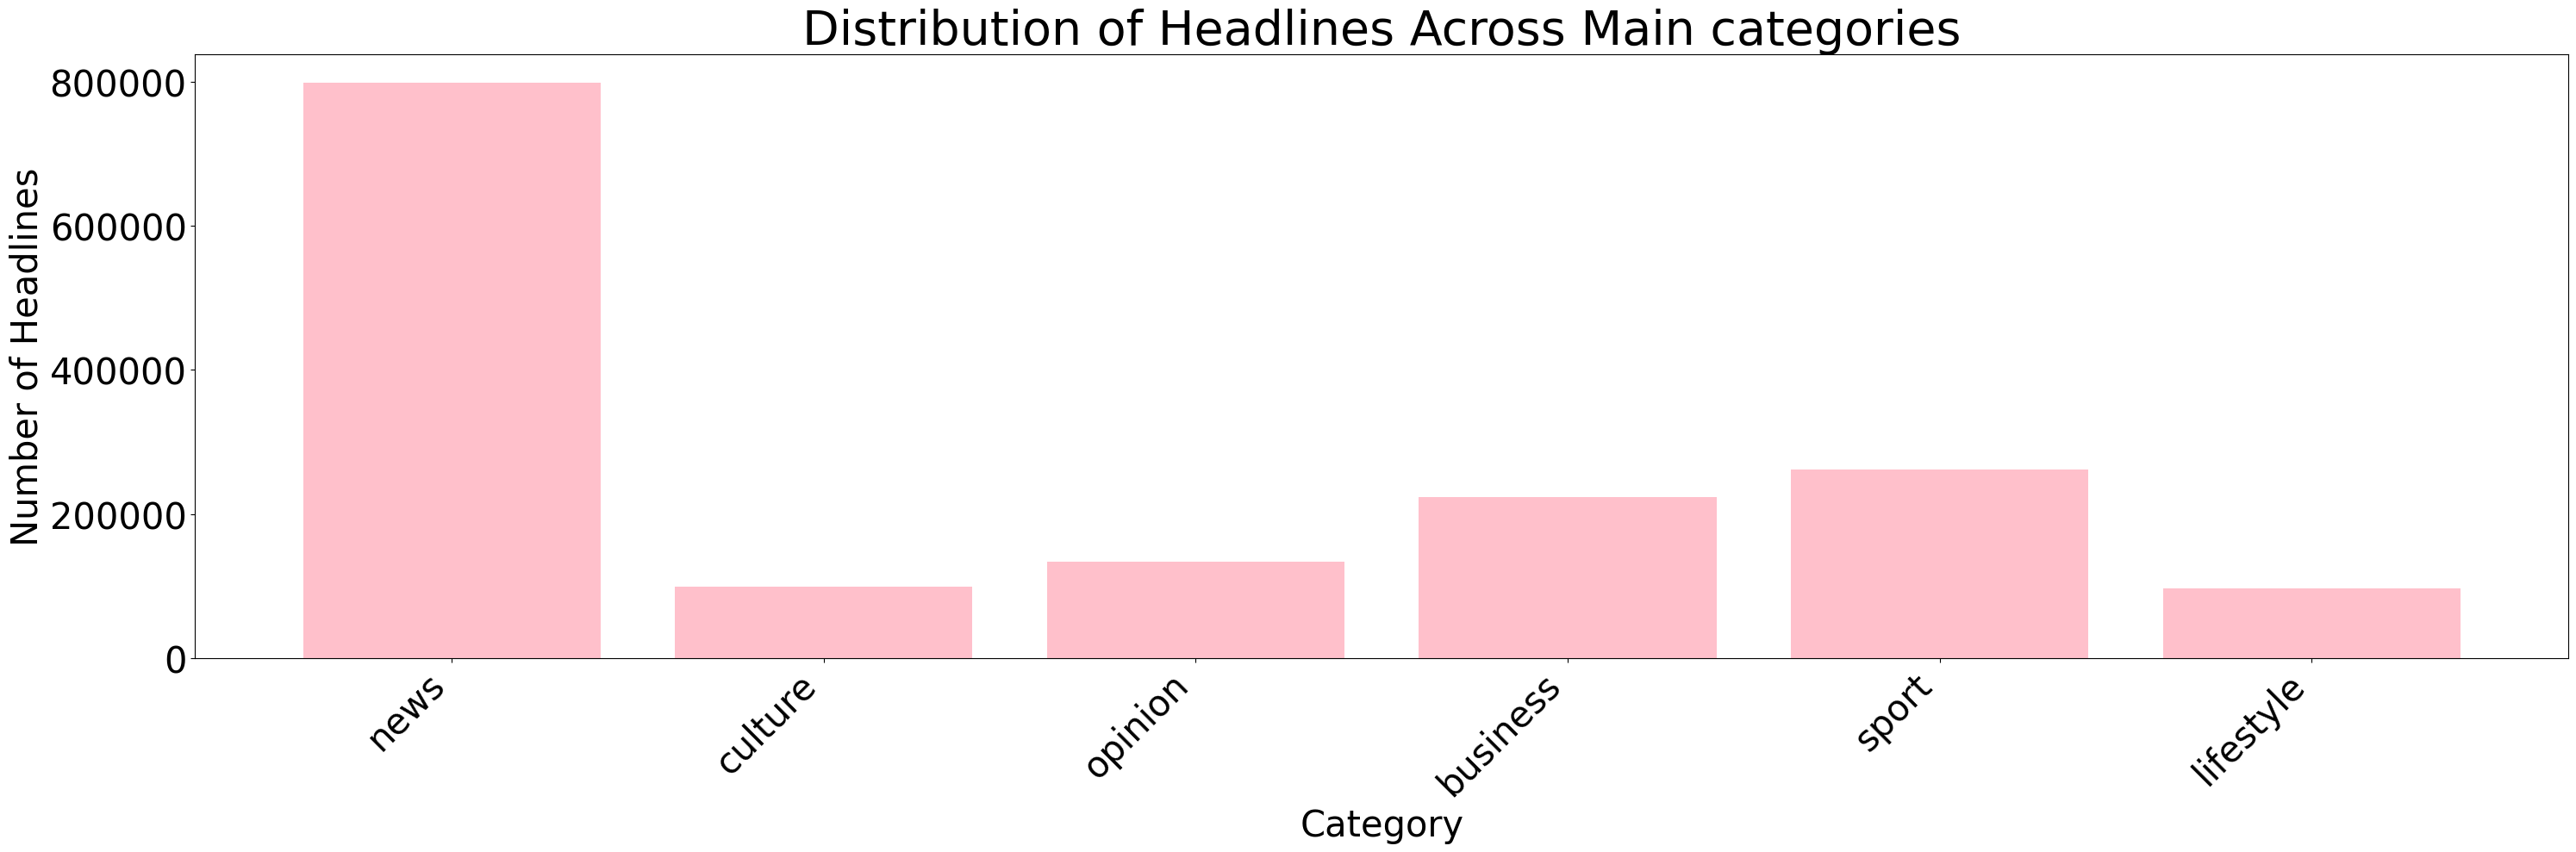

In [13]:
def number_of_rows_group_by_main_category():
    data['main_category'] = ['.'.join(data['headline_category'][i].split('.')[:1]) for i in range(data.shape[0])]


    filtered_data = data['main_category'].unique()

    categories = defaultdict(int)
    for category in filtered_data:
        count = len(data[data['main_category'] == category])
        categories[category]=count

    # Create a bar chart of the headline counts
    plt.bar(range(len(categories)), list(categories.values()),color='pink')
    plt.xticks(range(len(categories)), list(categories.keys()), rotation=45, ha='right',fontsize=30)
    plt.xlabel('Category',fontsize=30)
    plt.ylabel('Number of Headlines',fontsize=30)
    plt.tick_params(axis='y', labelsize=30)
    plt.title("Distribution of Headlines Across Main categories",fontsize=40)
    plt.tight_layout()
    plt.rcParams['figure.figsize'] = [30, 10]
    plt.show()

# Call the function
number_of_rows_group_by_main_category()

### Explaination of the results:
The bar chart highlights the imbalance in the distribution of headlines among the main categories. Some categories exhibit a significantly larger number of headlines, while others have comparatively fewer headlines associated with them.

This plot provides a visual representation of the imbalance in the distribution of headlines across the main categories, emphasizing the need for careful consideration of the data's representativeness when interpreting or analyzing the dataset.

### Words Cloud

The purpose of the word cloud plot is to provide a visual representation of the most frequently occurring words in the headlines of a specific category.

By generating a word cloud, the code allows for quick identification of common or significant terms associated with the specified category.

This visualization can aid in understanding the prominent themes or topics covered in the headlines for that particular category.

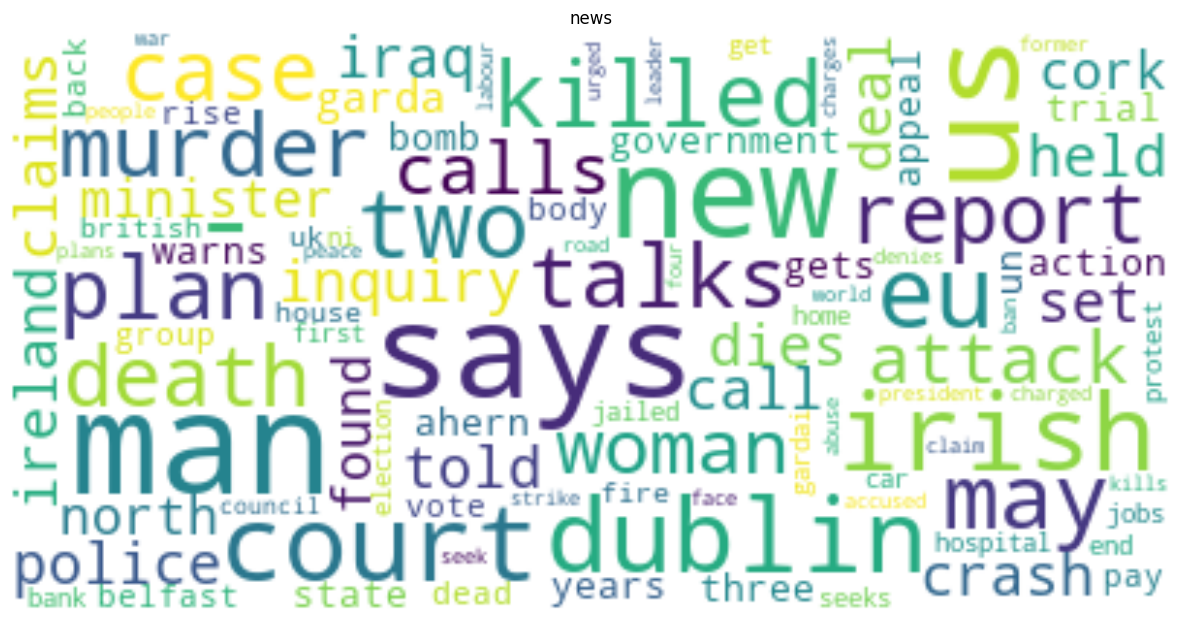

In [14]:
def frequency_word_per_category(category: str = 'news'):

    # Download stopwords from NLTK
    stopwords = set(nltk.corpus.stopwords.words('english'))

    # Filter the data based on the desired category
    filtered_data = data[data['updated_category'] == category].copy()

    if filtered_data.empty:
        print("No headlines found for the specified category.")
    else:
        # Extract the headlines
        headlines = filtered_data['headline_text']

        words = []
        for headline in headlines:
            words.extend(headline.lower().split())
        # Remove stopwords
        words = [word for word in words if word not in stopwords]
        word_counts = Counter(words)

        # Generate the word cloud
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(word_counts)

        # Plot the word cloud
        plt.figure(figsize=(15, 15))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(category)

        plt.show()

# Call the function
frequency_word_per_category()


### PCA

The purpose of the PCA plot is to visualize the embeddings of headlines from different categories in a reduced-dimensional space using PCA.

The code initializes a BERT model and tokenizer from the 'bert-base-uncased' pre-trained model.

By projecting the embeddings onto two or three dimensions, the code provides a visual representation that can reveal patterns, clusters, or separations between different categories of headlines.

This visualization can aid in exploring relationships and similarities among the headlines and potentially uncover underlying structures within the data.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


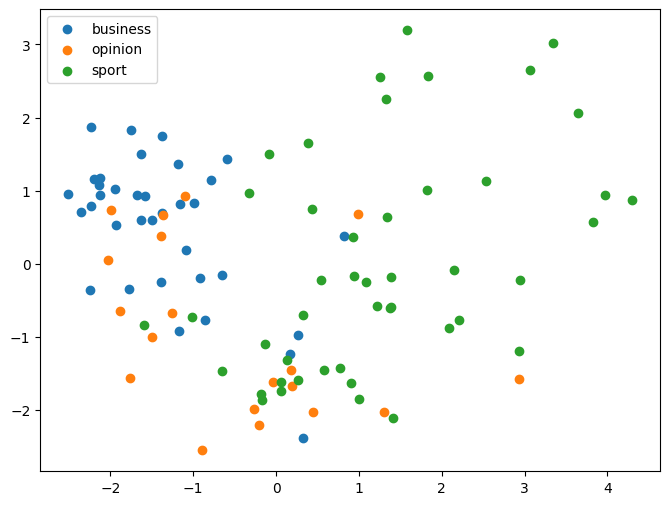

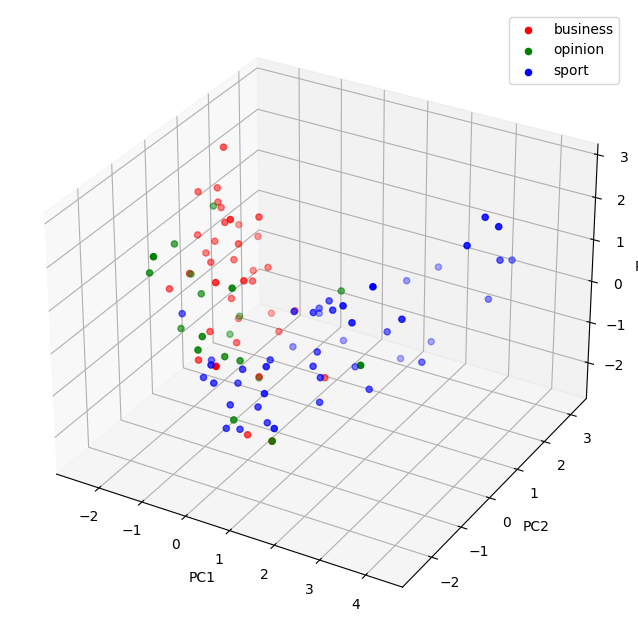

In [15]:
# you can repalce the categories here
CAT1 = 'opinion'
CAT2 = 'sport'
CAT3 = 'business'


def pca_embedding_vectors():
    model_name = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    categories = [CAT1, CAT2, CAT3]

    # Extract the headlines for the chosen categories
    filtered_data = data[data['updated_category'].isin(categories)].copy()

    # Select 100 random rows from the filtered data
    random_sample = filtered_data.sample(n=100, random_state=42)  # Adjust the number of samples (n) as desired
    headlines = random_sample['headline_text']

    # Tokenize input text
    tokenized_inputs = tokenizer(headlines.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=512, add_special_tokens=True)
    tokens = {
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask']
    }

    # Generate sentence embeddings
    with torch.no_grad():
        outputs = model(**tokens)
        embeddings = outputs.last_hidden_state.mean(dim=1)

    # Visualize embeddings
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    # Plot the chosen categories and headlines
    for i, (category, category_headlines) in enumerate(random_sample.groupby('updated_category')):
        if category in categories:
            indices = [j for j, x in enumerate(headlines) if x in category_headlines['headline_text'].tolist()]
            plt.scatter(principal_components[indices, 0], principal_components[indices, 1], label=category)
    plt.legend()
    plt.show()

    # Visualize embeddings
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(embeddings)

    # Plot the categories and headlines 3D
    fig = plt.figure(figsize=(10, 8))  # Set the figure size
    ax = fig.add_subplot(111, projection='3d')
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
    for i, (category, category_headlines) in enumerate(filtered_data.groupby('updated_category')):
        if category in categories:
            indices = [j for j, x in enumerate(headlines) if x in category_headlines['headline_text'].tolist()]
        ax.scatter(principal_components[indices, 0], principal_components[indices, 1], principal_components[indices, 2],
                   c=colors[i], label=category)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.legend()
    plt.show()

# Call the function
pca_embedding_vectors()


### Explaination of the results:
Upon analyzing the PCA plot, we see that the sports category possesses distinctive characteristics and exhibits a higher degree of concentration and separation in the PCA plot compared to the business and opinion categories.

This observation suggests that sports headlines have specific language patterns or thematic elements that differentiate them from other categories, highlighting the unique nature of sports-related news.

### Box plot and Sentence Complexity

The purpose of this plots is to provide a visual comparison of sentence complexity (as indicated by sentence lengths) across different categories of headlines.

The plot allows for easy identification of variations in sentence lengths, highlighting the diversity and distribution of sentence complexity within each category.

This visualization can aid in understanding the differences in writing style, linguistic patterns, or content characteristics among the various categories of headlines.

(200, 5)


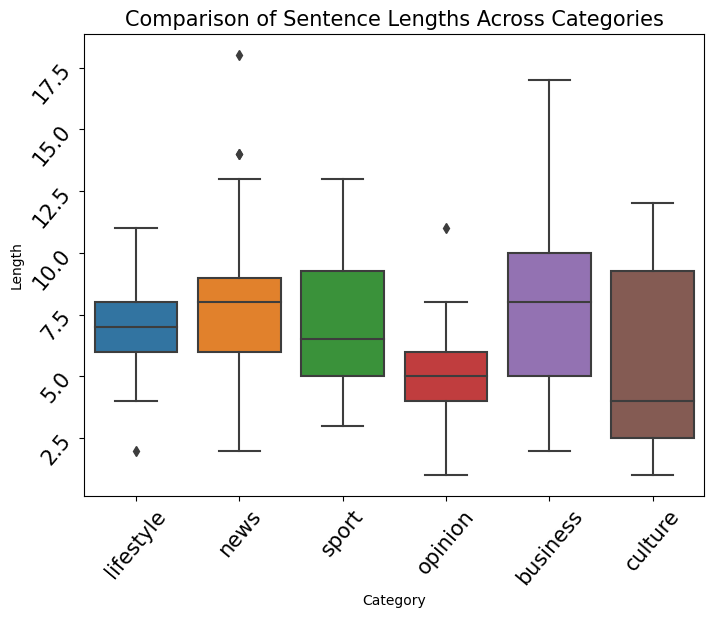

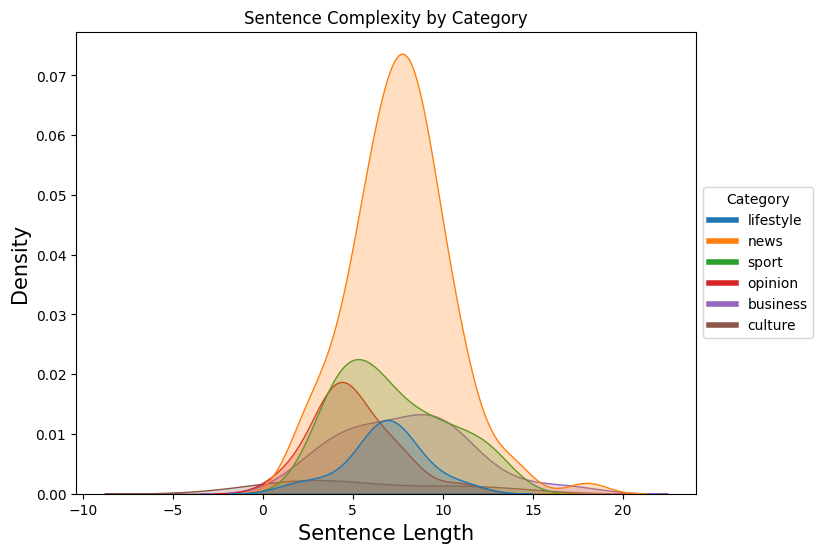

In [16]:
def Sentence_complexity_pox_plot(data):

    # Extract the categories and headlines
    categories_list = ['news','opinion','sport','business','culture','lifestyle']
    headlines = []
    #filtered_categories = data[data['updated_category'].str.startswith('business')]['updated_category'].unique()
    filtered_data = data[data['main_category'].isin(categories_list)].copy()
    # Select 100 random rows from the filtered data
    random_sample = filtered_data.sample(n=200, random_state=42)  # Adjust the number of samples (n) as desired
    print(random_sample.shape)
    categories = defaultdict(list)

    for _, row in random_sample.iterrows():
        category = row['main_category']
        headline = row['headline_text']
        categories[category].append(headline)
        headlines.append(headline)

    # Calculate sentence lengths for each category
    category_lengths = {}
    for category, headlines in categories.items():
        lengths = [len(headline.split()) for headline in headlines]
        category_lengths[category] = lengths

    # Create a DataFrame to use with Seaborn
    data = []
    for category, lengths in category_lengths.items():
        for length in lengths:
            data.append({'Category': category, 'Length': length})
    df = pd.DataFrame(data)

    # Create a box plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Category', y='Length', data=df)
    plt.xticks(rotation=50,fontsize=15)
    plt.title('Comparison of Sentence Lengths Across Categories',fontsize=15)
    plt.yticks(rotation=50,fontsize=15)
    plt.show()


    # Create a color palette with unique colors for each category
    unique_categories = list(category_lengths.keys())
    num_categories = len(unique_categories)
    palette = sns.color_palette('tab10', n_colors=num_categories)

    # Create a density plot
    plt.figure(figsize=(8, 6))
    ax = sns.kdeplot(data=df, x='Length', hue='Category', fill=True, palette=palette)

    # Add indications for each color on the side
    legend_elements = [plt.Line2D([0], [0], color=palette[i], lw=4, label=category)
                       for i, category in enumerate(unique_categories)]
    ax.legend(handles=legend_elements, title='Category', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Sentence Length',fontsize=15)
    plt.ylabel('Density',fontsize=15)
    plt.title('Sentence Complexity by Category')
    plt.show()


Sentence_complexity_pox_plot(data)

### Explaination of the results:
#### Box plot:
The findings suggest that the opinion and lifestyle categories tend to have shorter sentence lengths, with opinion having a slightly shorter median (5) length compared to lifestyle(7.5).

On the other hand, the culture category exhibits a wider range of sentence lengths, with a relatively shorter median length compared to the other categories.

These differences in sentence complexity can provide insights into the writing styles, content characteristics, or linguistic patterns prevalent in each category.

#### Distribution Plot:
The findings indicate that the news category has a more concentrated distribution, with a peak at around 7 words, suggesting a relatively common sentence length within that category.

On the other hand, the culture category has a more diverse distribution with a flatter curve, indicating a wider range of sentence lengths. This difference in distribution patterns provides insights into the typical sentence complexities and variations within each category.

# Cleaning the Data

In [17]:
# we noticed there are several headlines with different categories, so we will keep the latest one
filtered_data = pd.DataFrame(data.groupby(['headline_text'])[['publish_date','updated_category']].max()).reset_index()

In [18]:
# keep only headlines that contains English characters
english_pattern = re.compile(r'[a-zA-Z\s]+')
filtered_data['headline_text'] = filtered_data['headline_text'].apply(lambda x: ''.join(re.findall(english_pattern, str(x))))
# Drop rows with empty strings in any column
filtered_data = filtered_data.dropna()  # Drop rows with NaN values
#Drop empty string in any colum
filtered_data=filtered_data[filtered_data['headline_text'] != '']

In [19]:
filtered_data = filtered_data.drop(columns=['publish_date'])

In [20]:
filtered_data.head()

,headline_text,updated_category
0,Threr,culture.music
1,Ay Carmela,culture
2,Viva el documental,news
3,kaboogie,culture
4,million art theft from gallery in Manchester,news


# Balance the Data

In [21]:
categories = filtered_data['updated_category'].unique()
balanced_df = pd.DataFrame(columns=['headline_text','updated_category'])
for category in categories:
    temp_df = filtered_data[filtered_data['updated_category']==category].sample(3000, replace = True)
    balanced_df = pd.concat([balanced_df,temp_df], ignore_index=True)

In [22]:
balanced_df.groupby('updated_category').size()

updated_category
business                          3000
business.agribusiness-and-food    3000
business.commercial-property      3000
business.companies                3000
business.construction             3000
                                  ... 
sport.golf                        3000
sport.others                      3000
sport.racing                      3000
sport.rugby                       3000
sport.soccer                      3000
Length: 62, dtype: int64

In [23]:
# shuffle the data
balanced_df = balanced_df.sample(frac=1, ignore_index=True)

In [24]:
balanced_df.head()

,headline_text,updated_category
0,Naturally forgo heavy foundation for a summer ...,lifestyle.fashion
1,Ramone romps home to shock win over Weld and O...,sport.racing
2,Gerry Thornley Without crowds matches are just...,sport.rugby
3,Graham Crowley Nifty shades of grey and wild c...,culture.design
4,New DVD,culture


# Preprocessing

In [25]:
porter_stemmer = PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')
# defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

In [26]:
def preprocess(row):
    # lowercase
    pre_process_text = row.lower()
    # split the sentence to words
    pre_process_text = pre_process_text.split()
    # remove stop words
    pre_process_text = [i for i in pre_process_text if i not in stopwords]
    # stemmed the words
    pre_process_text = [porter_stemmer.stem(word) for word in pre_process_text]
    pre_process_text = [wordnet_lemmatizer.lemmatize(word) for word in pre_process_text]
    # return the words into sentence
    pre_process_text = " ".join([i for i in pre_process_text if i not in [',']])
    pre_process_text = "".join([i for i in pre_process_text if i not in punctuation])
    return pre_process_text

balanced_df['text'] = balanced_df.headline_text.apply(lambda x : preprocess(x))

In [27]:
#Drop empty string in any colum
balanced_df=balanced_df[balanced_df['text'] != '']

In [28]:
balanced_df= balanced_df.drop(columns=['headline_text'])

In [29]:
balanced_df.head()

,updated_category,text
0,lifestyle.fashion,natur forgo heavi foundat summer glow
1,sport.racing,ramon romp home shock win weld obrien hors
2,sport.rugby,gerri thornley without crowd match upgrad trai...
3,culture.design,graham crowley nifti shade grey wild colour
4,culture,new dvd


In [30]:
balanced_df.to_csv(Path(data_path, 'balanced_df.csv'), index=False)